## Introduction

The following model uses differential equations and a Finite State Machine (FSM) framework, building off of the SIRD model to create a realistic model for the spread of disease.

Healthy (H):
$ \frac{dH}{dt} = aM - bHC $

Incubating (I):
$ \frac{dI}{dt} = bHC - cI $

Contagious (C):
$ \frac{dC}{dt} = cI - (d+e+f)C $

Bed-ridden (B):
$ \frac{dB}{dt} = dC - (g+h)B $

Immune (M):
$ \frac{dM}{dt} = eC + hB - aM $

Dead (D):
$ \frac{dD}{dt} = fC + gB $




In [22]:
# Imports and defaults
import numpy as np
import random

"""This is used to represent an individual that is susceptible to infection."""
PRESET_STATE_HEALTHY = 0
"""This is used to represent an individual that is infected and incubating, but
is not showing symptoms, and which is not capable of transmission yet."""
PRESET_STATE_INCUBATE = 1
"""This is used to represent an individual that is currently infected and symptomatic,
and capable of infecting Healthy individuals."""
PRESET_STATE_CONTAGIOUS = 2
"""This is used to represent an individual that is currently infected and symptomatic,
but is much less likely to expose others to infection by being confined to bedrest.
Also improves the patient's chances of survival slightly."""
PRESET_STATE_BEDRIDDEN = 3
"""This is used to represent an individual that was infected, but has recovered.
This will give the individual one week of guaranteed infection immunity."""
PRESET_STATE_RECOVERED = 4
"""This is used to represent an individual that was infected and succumbed to the
disease in question."""
PRESET_STATE_DECEASED = 5

In [24]:
# Disease Parameters

"""This modifier controls the likelihood of a Contagious individual exposing
and infecting a Healthy individual. It is the chance, before any individual
resistance or connection modifiers, of infection occurring. Values are
expected to be in the range [0.05, 0.9]."""
PARAM_DISEASE_SPREAD = 0.25
"""This modifier controls the minimum number of days that the disease will
Incubate in an infected individual. Values are expected to be in the range
[1, 10]."""
PARAM_DISEASE_INCUBATION_MIN = 3
"""This modifier controls the maximum number of days that the disease can
Incubate in an infected individual. Values are expected to be in the range
[2, 14]."""
PARAM_DISEASE_INCUBATION_MAX = 10
"""This modifier controls the target number of days that the disease will be
Contagious in an infected individual. Values are expected to be in the range
[3, 21]."""
PARAM_DISEASE_CONTAGIOUS_TARGET = 10
"""This modifier controls the maximum 'progress' of the disease in an individual.
Every step of progress will slightly reduce the chance of progressing into the next,
but will also increase the chance of fatality. Values are expected to be in the
range [2, 20]. Newly-contagious individuals will start at Progress 0."""
PARAM_DISEASE_PROGRESS_MAX = 10
"""This modifier adjusts the risk of a Contagious case of the disease getting
worse for the patient. Values are expected to be in the range [0.01, 0.75]."""
PARAM_DISEASE_PROGRESS_UP = 0.3
"""This modifier adjusts the chance of a Contagious case of the disease getting
better for the patient. Values are expected to be in the range [0.01, 0.75]."""
PARAM_DISEASE_PROGRESS_DOWN = 0.15
"""This modifier controls the base risk of mortality associated with the disease.
Values are expected to be in the range [0, 0.2] for the baseline."""
PARAM_DISEASE_FATALITY_BASE = 0.002
"""This modifier controls the maximum risk of mortality associated with a very
bad case of the disease. Values are expected to be in the range [0.01, 0.9]."""
PARAM_DISEASE_FATALITY_LIMIT = 0.07

In [26]:
################################################################################
# Population Parameters

"""This modifier controls the total number of individuals in the population
being simulated. Values are expected to be in the range [10, 5000000]."""
PARAM_POPULATION_START = 4000

# The following variables pertain to "connections," which represents the 
# avenues for infection that this disease possesses.
"""This modifier controls the number of 'strong' connections that every
individual in the population is expected to have to other individuals. Values
are expected to be in the range [0, 12]."""
PARAM_POPULATION_STRONGCOUNT = 3
"""This modifier controls the number of 'weak' connections that every
individual in the population is expected to have to other individuals. Values
are expected to be in the range [2, 30]."""
PARAM_POPULATION_WEAKCOUNT = 5

"""This modifier controls the average 'health' of individuals in the population.
The individual health modifier adjusts risk of infection and fatality slightly.
Values are expected to be in the range [0.2, 0.8]."""
PARAM_POPULATION_AVGHEALTH = 0.35
"""This modifier controls the variation in the health modifiers of individuals in
the population. Values are expected to be in the range [0.05, 0.35], and the final
health modifier for any given individual will be capped to the range [0.1, 0.9]."""
PARAM_POPULATION_VARHEALTH = 0.15
"""This modifier controls the number of spontaneous exposures to attempt every day.
The likelihood of a random exposure causing infection is dependent on the proportion
of the population already infected, and on the health of the individual picked.
Values are expected to be in the range [1, 10]."""
PARAM_POPULATION_BONUS_EXPOSURES = 2
"""This modifier controls the likelihood of an infected individual being placed
into bedrest for recovery. Values are expected to be in the range [0.01, 0.4]."""
PARAM_POPULATION_BEDREST_CHANCE = 0.1
"""This modifier controls the maximum number of individuals allowed to be in bed-
rest overall. Values are expected to be in the range [1, (population / 5)]."""
PARAM_POPULATION_BEDREST_MAX = 40

In [28]:
# Simulation control parameters

"""This modifier controls the duration of the simulation, generally. Values are
expected to be in the range [10, 300]."""
PARAM_SIMULATION_DAYS = 40
"""This modifier controls the number of subdivisions (for disease progress and
infection chances) to perform during every simulation day. Values are expected
to be in the range [1, 6]."""
PARAM_SIMULATION_SUBDAYS = 3

In [30]:
"""Core Individual class. This is a single node within the undirected graph
structure that represents the simulated population. It tracks its own disease
state, strong and weak connections, and a health multiplier."""
class SimIndividual:
    def __init__(self, health: float = 0.0):
        """Construct a new Simulation Individual. If 'health' is set to 0.0, it
        will be automatically generated based on the population parameters."""
        self.state = {'main':PRESET_STATE_HEALTHY, 'subdays_active':0, 'progress':0, 
                      'update_subday_cnt':0, 'update_propensities':None}
        # 'subdays_active' tracks the amount of time the individual is in a state
        # 'progress' tracks Disease progress, if relevant
        # 'update_subday_cnt' tracks the timepoint for the next progress or state update
        # 'update_propensities' stores the propensities for the next state change, if relevant
        self.connect_strong = [None] * PARAM_POPULATION_STRONGCOUNT
        self.connect_strong_cnt = 0 # this is used to determine where we register
        self.connect_weak = [None] * PARAM_POPULATION_WEAKCOUNT
        self.connect_weak_cnt = 0
        if health == 0.0:
            self.health = min(0.9, max(0.1, random.gauss(PARAM_POPULATION_AVGHEALTH, PARAM_POPULATION_VARHEALTH)))
        else:
            self.health = health
            
    def assign_connection(self, who, strong: bool = False) -> bool:
        """Attempt to add a two-way connection between this Individual and the
        specified target Individual, of the specified strength level. Returns
        True if both Individuals had an open slot for the connection and one
        was successfully established, False otherwise."""
        if strong:
            selfallowed = self.connect_strong_cnt < PARAM_POPULATION_STRONGCOUNT \
                          and not (who in self.connect_strong)
            themallowed = who.connect_strong_cnt < PARAM_POPULATION_STRONGCOUNT \
                          and not (self in who.connect_strong)
            if selfallowed and themallowed:
                self.connect_strong[self.connect_strong_cnt] = who
                who.connect_strong[who.connect_strong_cnt] = self
                self.connect_strong_cnt += 1
                who.connect_strong_cnt += 1
                return True
            else:
                return False
        else:
            selfallowed = self.connect_weak_cnt < PARAM_POPULATION_WEAKCOUNT \
                          and not (who in self.connect_weak)
            themallowed = who.connect_weak_cnt < PARAM_POPULATION_WEAKCOUNT \
                          and not (self in who.connect_weak)
            if selfallowed and themallowed:
                self.connect_weak[self.connect_weak_cnt] = who
                who.connect_weak[who.connect_weak_cnt] = self
                self.connect_weak_cnt += 1
                who.connect_weak_cnt += 1
                return True
            else:
                return False

    def change_core_state(self, new_state: int) -> bool:
        """Attempt to change the current simulation state of this Individual to
        the specified integer, representing one of the PRESET_STATE entries.
        Returns True if the state was modified, False otherwise."""
        if self.state['main'] == new_state:
            return False
        else:
            self.state['main'] = new_state
            self.state['last_subdays'] = self.state['subdays_active']
            self.state['subdays_active'] = 0
            # perform "first change" logic for disease states
            if new_state == PRESET_STATE_INCUBATE:
                targetnum = random.randint(PARAM_SIMULATION_SUBDAYS * PARAM_DISEASE_INCUBATION_MIN,\
                                           PARAM_SIMULATION_SUBDAYS * PARAM_DISEASE_INCUBATION_MAX)
                self.state['update_subday_cnt'] = targetnum
            elif new_state == PRESET_STATE_CONTAGIOUS:
                self.state['update_propensities'] = self.disease_substate_nextgoal()
            elif new_state == PRESET_STATE_RECOVERED:
                self.state['update_subday_cnt'] = PARAM_SIMULATION_SUBDAYS * 7
            return True

    def disease_substate_nextgoal(self) -> tuple:
        """Determines the number of subdays until the next expected disease update,
        and assigns that to this Individual's state. Returns a tuple, containing
        the propensities for their condition worsening."""
        
        subday_fraction = self.state['subdays_active'] / (PARAM_DISEASE_CONTAGIOUS_TARGET * PARAM_SIMULATION_SUBDAYS)
        if self.state['progress']:
            prop_up = PARAM_DISEASE_PROGRESS_UP * (1 + 0.1 * (PARAM_DISEASE_PROGRESS_MAX - self.state['progress'])) \
                    * (1 - 0.1 * self.health) / (1 + 4 * subday_fraction)
            prop_dn = PARAM_DISEASE_PROGRESS_DOWN * (1 + subday_fraction) * (1 + 0.1 * self.health) \
                    * (0.2 + 0.5 * self.state['progress'] / PARAM_DISEASE_PROGRESS_MAX)
            
            target = round(PARAM_SIMULATION_SUBDAYS * random.expovariate(1.0 / (prop_up + prop_dn)))
            self.state['update_subday_cnt'] = target
            return (prop_up, prop_dn)
        else:
            target = round(PARAM_SIMULATION_SUBDAYS * random.expovariate(1.0 / PARAM_DISEASE_PROGRESS_UP))
            self.state['update_subday_cnt'] = target
            return (PARAM_DISEASE_PROGRESS_UP, 0.0)

    def debug_print(self):
        print(self.state, self.health, self.connect_strong_cnt, self.connect_weak_cnt)
    
    def state_subday_simulate(self):
        """Perform one sub-day of simulation for this Individual's state."""
        self.state['subdays_active'] += 1
        statenum = self.state['main']
        if statenum and self.state['subdays_active'] >= self.state['update_subday_cnt']:
            if statenum == PRESET_STATE_INCUBATE:
                # Disease progresses from Incubating to Contagious
                self.change_core_state(PRESET_STATE_CONTAGIOUS)
            elif statenum == PRESET_STATE_CONTAGIOUS:
                worsens = random.choices([True, False], self.state['update_propensities'])[0]
                if worsens:
                    self.state['progress'] += 1
                    if self.state['progress'] >= PARAM_DISEASE_PROGRESS_MAX:
                        self.state['progress'] = PARAM_DISEASE_PROGRESS_MAX
                else:
                    self.state['progress'] -= 1
                    if self.state['progress'] <= 0:
                        self.change_core_state(PRESET_STATE_RECOVERED)
                self.state['update_propensities'] = self.disease_substate_nextgoal()
                deathrisk = PARAM_DISEASE_FATALITY_BASE + ((PARAM_DISEASE_FATALITY_LIMIT - PARAM_DISEASE_FATALITY_BASE) \
                            * (self.state['progress'] / PARAM_DISEASE_PROGRESS_MAX))
                deathrisk *= (1.0 - 0.25 * self.health) / (1 + PARAM_SIMULATION_SUBDAYS) # fatality_base is in daily terms

                if random.uniform(0.0, 1.0) < deathrisk:
                    self.change_core_state(PRESET_STATE_DECEASED)
                    return
                
                # TO-DO: implement bedridden

# get some stats for starting evaluation
times_to_recovery = 0
times_recovered = 0
times_to_death = 0
times_died = 0

for iteration in range(500):    
    rob = SimIndividual(0.15)
    rob.change_core_state(PRESET_STATE_INCUBATE)
    for i in range(PARAM_SIMULATION_SUBDAYS * PARAM_SIMULATION_DAYS):
        rob.state_subday_simulate()
        if rob.state['main'] == 5:
            times_to_death += rob.state['last_subdays']
            times_died += 1
            break
        elif rob.state['main'] == 4:
            times_to_recovery += rob.state['last_subdays']
            times_recovered += 1
            break

print("For 500 simulations,", times_recovered, "recovered and", times_died, "died.")
print("The average recovery time was", times_to_recovery / times_recovered, "subdays (", times_to_recovery \
    / (times_recovered * PARAM_SIMULATION_SUBDAYS), "days)")
print("The average death time was", times_to_death / times_died, "subdays (", times_to_death \
    / (times_died * PARAM_SIMULATION_SUBDAYS), "days)")
print("Fatality parameters were", PARAM_DISEASE_FATALITY_BASE, "base and", PARAM_DISEASE_FATALITY_LIMIT, "max")
print("Target disease duration was", PARAM_DISEASE_CONTAGIOUS_TARGET, "days")

For 500 simulations, 355 recovered and 145 died.
The average recovery time was 39.183098591549296 subdays ( 13.061032863849766 days)
The average death time was 20.46206896551724 subdays ( 6.820689655172414 days)
Fatality parameters were 0.002 base and 0.07 max
Target disease duration was 10 days


In [202]:
################################################################################
# A Class for the simulator itself, which generates individuals and updates 
# their states one-by-one
class Simulator:

    # Setup function
    def __init__(self, population_size):
        """Creates a simulator object, which will generate individuals, tell 
        them to update their states, and collect data on the states of 
        individuals."""
        self.population_size = population_size
        self.individuals = [None] * population_size
        self.individual_counts_in_each_state = {
            PRESET_STATE_HEALTHY: 0,
            PRESET_STATE_INCUBATE: 0,
            PRESET_STATE_CONTAGIOUS: 0,
            PRESET_STATE_BEDRIDDEN: 0,
            PRESET_STATE_RECOVERED: 0,
            PRESET_STATE_DECEASED: 0
        }

        # Define some other parameters
        self.simulation_iteration_length = PARAM_SIMULATION_DAYS * \
            PARAM_SIMULATION_SUBDAYS

        # Create a dictionary to store simulation data for reference later; 
        # These values are on a per-subday basis. Taking their sum gives the 
        # total values across the current iteration.
        self.per_subday_simulation_data = {
            "recoveries": np.zeros(self.simulation_iteration_length),
            "deaths": np.zeros(self.simulation_iteration_length),
            "current_healthy": np.zeros(self.simulation_iteration_length),
            "current_incubating": np.zeros(self.simulation_iteration_length),
            "current_contagious": np.zeros(self.simulation_iteration_length),
            "current_bedridden": np.zeros(self.simulation_iteration_length),
            "current_recovered": np.zeros(self.simulation_iteration_length),
            "current_deceased": np.zeros(self.simulation_iteration_length)
        }

        # Create a list to store each iteration of the simulation
        self.per_iteration_simulation_data = [None]

        # Store a population's worth of individuals into the individuals list
        for i in range(population_size):
            self.individuals[i] = SimIndividual(0.15)
    

    # Callable functions
    def perform_single_simulation(self):
        """Perform the simulation outlined in the parameters of this program 
        and this class."""
        # Start by resetting the individuals list and initializing the
        # individuals' connections
        self.initialize_individuals()

        # TODO: implement the code from the previous box.

        return self.per_subday_simulation_data

    def perform_iterated_simulation(self, iterations):
        """Given the number of iterations, perform the simulation outlined
        in the parameters of this program and this class."""

        # Update the per-iteration simulation data
        self.per_iteration_simulation_data = [None] * iterations

        for iteration in range(500):    
            # TODO: implement the code from the previous box.
            pass
    

    # Utility functions
    def initialize_individuals(self):
        """Fill the individuals array with SimIndividual objects and 
        connect each individual to a random assortment of others according
        to simulation parameters."""
        # Loop over each entry in the individuals array
        for i in range(self.population_size):
            # Create an individual and put it in this entry (overwrite 
            # previous individuals)
            self.individuals[i] = SimIndividual()
        
        # Now that all individuals are initialized, loop over all of them
        # once more to add strong and weak connections
        for i in range(self.population_size):
            # Get the data for the current individual
            this_individual = self.individuals[i]
            
            # Count how many strong connections have been successfully made
            # for this individual
            strong_connections_made = this_individual.connect_strong_cnt

            # Ensure that the simulation doesn't run too inefficiently or forever
            attempts = 0

            # While not enough strong connections have been made for this 
            # individual, add more
            while strong_connections_made < PARAM_POPULATION_STRONGCOUNT \
                  and attempts < 11:
                # Count number of attempts
                attempts += 1
                
                # Grab another random individual
                random_individual_id = i
                # Ensure that the random individual is not this individual
                while random_individual_id == i:
                    random_individual_id = \
                        random.randint(0,self.population_size-1)
                
                # Grab this individual's data from the population
                random_individual = self.individuals[random_individual_id]
                
                # If this connection was made successfully, increment the 
                # strong connections made counter
                if this_individual.assign_connection(random_individual,\
                                                     strong=True):
                    strong_connections_made += 1
                

            # --Repeat above code but for weak connections--
            # Count how many weak connections have been successfully made
            # for this individual
            weak_connections_made = this_individual.connect_weak_cnt

            # Reset attempt counter
            attempts = 0

            # While not enough weak connections have been made for this 
            # individual, add more
            while weak_connections_made < PARAM_POPULATION_WEAKCOUNT \
                  and attempts < 11:
                # Count number of attempts
                attempts += 1
                
                # Grab another random individual
                random_individual_id = i
                # Ensure that the random individual is not this individual
                while random_individual_id == i:
                    random_individual_id = \
                        random.randint(0,self.population_size-1)
                
                # Grab this individual's data from the population
                random_individual = self.individuals[random_individual_id]
                
                # If this connection was made successfully, increment the 
                # weak connections made counter
                if this_individual.assign_connection(random_individual,\
                                                     strong=False):
                    weak_connections_made += 1

    def get_individual_array(self):
        return self.individuals

In [76]:
import networkx as nx

def build_population_graph(individuals):
    """Generates a networkX graph by creating a node for every 
    individual in the simulation, and creating edges for every weak
    and strong connection"""
    
    G = nx.Graph()

    # Map individuals to integer IDs
    id_map = {ind: idx for idx, ind in enumerate(individuals)}

    # Add a node for every person
    for idx in range(len(individuals)):
        G.add_node(idx)

    # Add all the edges
    for person in individuals:
        this_id = id_map[person]

        # Strong connections
        for neighbor in person.connect_strong[:person.connect_strong_cnt]:
            neighbor_id = id_map[neighbor]
            if this_id < neighbor_id:  # prevent adding duplicate undirected edges
                G.add_edge(this_id, neighbor_id, type="strong")

        # Weak connections
        for neighbor in person.connect_weak[:person.connect_weak_cnt]:
            neighbor_id = id_map[neighbor]
            if this_id < neighbor_id:
                G.add_edge(this_id, neighbor_id, type="weak")

    return G

In [198]:
import plotly.graph_objects as go

def plot_graph_plotly(G, pos):
    """Converts our networkX data to datatypes plotly can understand
    and generates our graph"""
    
    # Initialize edge traces
    strong_x, strong_y = [], []
    weak_x, weak_y = [], []

    # unpack our position data
    for u, v, data in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]

        if data["type"] == "strong":
            strong_x += [x0, x1, None]
            strong_y += [y0, y1, None]
        else:
            weak_x += [x0, x1, None]
            weak_y += [y0, y1, None]

    # Make our strong edge objects
    strong_edges = go.Scatter(
        x=strong_x, y=strong_y,
        mode="lines",
        line=dict(width=3, color="purple"),
        name="Strong connections"
    )

    # Make our weak edge objects
    weak_edges = go.Scatter(
        x=weak_x, y=weak_y,
        mode="lines",
        line=dict(width=1, color="teal"),
        name="Weak connections"
    )

    # Nodes/Individuals
    # unpack node position (we will be using networkX to generate this)
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]

    # make our node objects
    nodes = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        marker=dict(
            size=8,
            color="darkblue"
        ),
        name="Individuals"
    )

    # settings for how the graph looks
    fig = go.Figure(data=[strong_edges, weak_edges, nodes])

    fig.update_layout(
        title="Connections Between People",
        showlegend=True,
        hovermode='closest', #change to number of connections or ID
        width=900,
        height=700,
        plot_bgcolor="lightgray",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False), # format for x and y axis
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    fig.update_traces(marker=dict(size=12, 
                            line=dict(width=2, 
                            color='White')))
    fig.show()

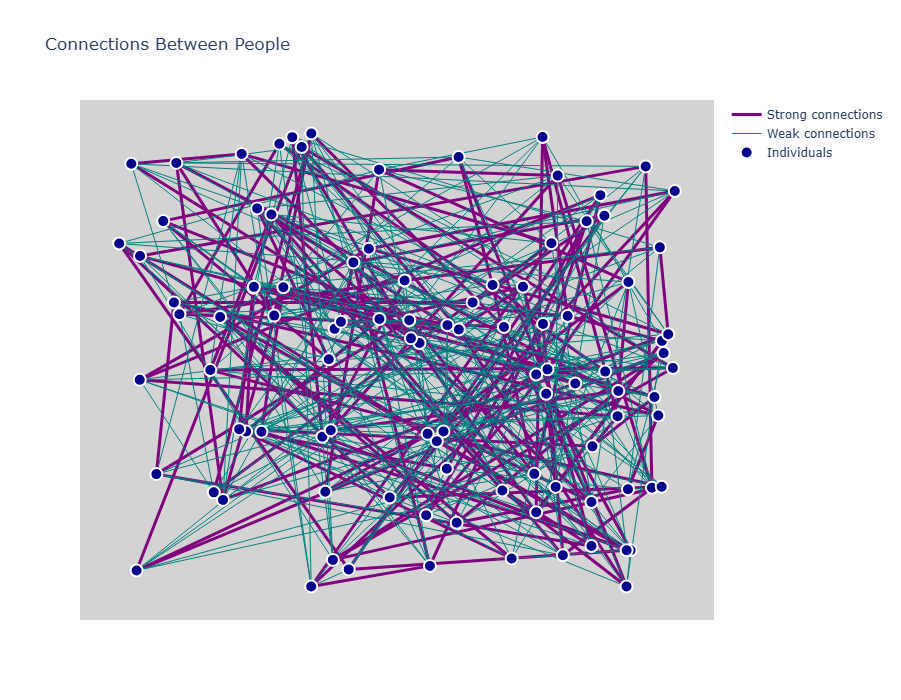

In [200]:
def compute_layout(G):
    """uses networkX's random layout to generate locations for our nodes"""
    return nx.random_layout(G,center=(0,0),dim=2)

# Run the simulator
sim = Simulator(100)   # or your preferred size
sim.perform_single_simulation()

individuals = sim.get_individual_array()

# Build the graph
G = build_population_graph(individuals)

# Compute layout
pos = compute_layout(G)

# Display
plot_graph_plotly(G, pos)